<h2>Imports</h2>

In [1]:
import os
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime as dt
import mplfinance as mpf

import time

<h2>Default Values</h2>

In [2]:
PATH="C:/Users/Zak/Documents/Programming/Data_Science/Finance/finance_course/Stock_list/"
import default_values

<h2>Get Stock File Names in a List</h2>

In [3]:
# listdir is going to return all files in the directory, if the thing listed is a file, then we'll store its name in a "files" list
files = [x for x in listdir(PATH) if isfile (join(PATH,x))]

# and now remove the ".csv" extenstion
tickers = [os.path.splitext(x)[0] for x in files]

<h2>Returns a Dataframe from a CSV</h2>

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv')
        df = df[::-1]
    except FileNotFoundError:
        print("File Doesn't exist")
    else:
        return df

<h2>Save Dataframe to CSV & Delete Unnamed Columns</h2>

In [5]:
def save_df_to_csv(df, ticker):
    df.to_csv(PATH + ticker + '.csv')
    
def delete_unnamed_cols(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df

<h2>Return Valid Dates in Dataframe</h2>

Checks if the dates are good as far as if the stock market is open that day etc...

In [6]:
def get_valid_dates(df, sdate, edate):
    try:
        mask = (df['Date'] > sdate) & (df['Date'] <= edate)
        # create smaller dataframe that only gets the valid dates set by the mask
        sm_df = df.loc[mask]
        # set indices as dates
        sm_df = sm_df.set_index(['Date'])
        # get first and last dates of the date range
        first_date = sm_df.index.min()
        last_date = sm_df.index.max()
        
        # if the date has only one number (like 1-1-2021), then a '0' is added before
        date_leading = '-'.join( ('0' if len(x) < 2 else '') + x for x in first_date.split('-') )
        date_ending = '-'.join( ('0' if len(x) < 2 else '') + x for x in last_date.split('-') )
    except Exception:
        print("Date Corrupted")
    else:
        return date_leading, date_ending
        
        

<h2>ROI over time</h2>

In [7]:
def roi_between_dates(df, sdate, edate):
    try:
        # Gets the Adj Close price for 1st & last date 
        start_val = df.loc[sdate]['Adj Close'] 
        end_val = df.loc[edate]['Adj Close'] 
        roi = ((end_val - start_val) / start_val)
    except Exception:
        print("Data Corrupted")
    else:
        return roi

<h2>Mean between Dates</h2>

In [8]:
def get_mean_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]['Adj Close'].mean()

<h2>Standard Deviation between dates</h2>

In [9]:
def get_sd_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]['Adj Close'].std()

<h2>Covariance</h2>

In [10]:
def get_cov_between_dates(df, sdate, edate):
    return (get_sd_between_dates(df,sdate,edate) / get_mean_between_dates(df,sdate,edate))

<h2>Test Functions</h2>

In [11]:
print("=========================")
print("Testing for : ", tickers[0])
print("=========================")

stock_a = get_df_from_csv(tickers[0])

print(get_valid_dates(stock_a,'2020-01-01','2020-12-31'))
sdate, edate = get_valid_dates(stock_a,'2020-01-01','2020-12-31')
print("Ajd Close Mean: ", get_mean_between_dates(stock_a, sdate, edate))
print("Ajd Close Standard Deviation: ", get_sd_between_dates(stock_a, sdate, edate))
print("Ajd Close Covariance: ", get_cov_between_dates(stock_a, sdate, edate))
stock_a = stock_a.set_index(['Date'])
print("ROI: ", roi_between_dates(stock_a, sdate, edate))
print("=========================")
print()

print("=========================")
print("Testing for CSCO")
print("=========================")
stock_b = get_df_from_csv('CSCO')
sdate, edate = get_valid_dates(stock_b,'2020-01-01','2020-12-31')
print("Ajd Close Mean: ", get_mean_between_dates(stock_b, sdate, edate))
print("Ajd Close Standard Deviation: ", get_sd_between_dates(stock_b, sdate, edate))
print("Ajd Close Covariance: ", get_cov_between_dates(stock_b, sdate, edate))
stock_b = stock_b.set_index(['Date'])
print("ROI: ", roi_between_dates(stock_b, sdate, edate))
print("=========================")



Testing for :  AA
('2020-01-02', '2020-12-31')
Ajd Close Mean:  13.356706361922006
Ajd Close Standard Deviation:  4.545523786027696
Ajd Close Covariance:  0.3403177147763248
ROI:  0.07609706605792996

Testing for CSCO
Ajd Close Mean:  41.57403742320954
Ajd Close Standard Deviation:  3.446306017645834
Ajd Close Covariance:  0.08289562985099601
ROI:  -0.05100995551625191


<h2>COV & ROI for all stocks over a defined period</h2>

In [12]:
def get_cov_roi(tickers, sdate, edate):
    col_names = ["Ticker", "COV", "ROI"]
    df = pd.DataFrame(columns= col_names)
    for ticker in tickers:
        # print("Working on : ", ticker)
        s_df = get_df_from_csv(ticker)
        sdate2, edate2 = get_valid_dates(s_df, sdate, edate)
        cov = get_cov_between_dates(s_df, sdate2, edate2)
        s_df = s_df.set_index(['Date'])
        roi = roi_between_dates(s_df, sdate2, edate2)
        df.loc[len(df.index)] = [ticker, cov, roi]
    return df

In [13]:
market_df = get_cov_roi(tickers, '2019-01-01', '2019-12-31')
market_df

,Ticker,COV,ROI
0,AA,0.158993,-0.180259
1,AAL,0.094255,-0.106021
2,AAME,0.123107,-0.202506
3,AAOI,0.202465,-0.251889
4,AAON,0.096021,0.418350
...,...,...,...
2901,ZSAN,0.372906,-0.350427
2902,ZTS,0.129821,0.576627
2903,ZUMZ,0.146251,0.760448
2904,ZYNE,0.376312,0.623656


In [14]:
print("Best 20 Stocks based on ROI")
market_df.sort_values(by=['ROI'], ascending = False).head(20)

Best 20 Stocks based on ROI


,Ticker,COV,ROI
286,AXSM,0.745206,37.567163
791,DRRX,0.566453,6.037037
1622,MBOT,0.290907,4.438503
866,ENPH,0.447633,4.310975
1908,OESX,0.402282,4.000000
220,ARWR,0.496426,3.834604
2806,WKHS,0.526715,3.676923
2238,ROKU,0.374797,3.117466
1689,MLSS,0.570364,3.088235
1521,LEU,0.346334,3.047059


<h2></h2>

<h2>Merge multiple Stocks in One Dataframe by Column name</h2>

In [52]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        print("Working on : ", x)
        df['Date'] = pd.to_datetime(df['Date'])
        # Use a mask to grab data between defined dates
        mask = (df['Date'] >= sdate) & (df['Date'] <= edate)
        print("colname",col_name)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

<h2>Create a Correlation Matrix using FAANGS</h2>

@TODO fix with AAPL and AMZN

In [55]:
faang_list = ["FB", "NFLX", "GOOG", "MSFT"]#,"AAPL","AMZN"]
mult_df = merge_df_by_column_name('daily_return',  '2020-1-1', '2020-12-31', *faang_list)
mult_df.corr()

Working on :  FB
colname daily_return
Working on :  NFLX
colname daily_return
Working on :  GOOG
colname daily_return
Working on :  MSFT
colname daily_return


,FB,NFLX,GOOG,MSFT
FB,1.000000,0.595254,0.810791,0.776997
NFLX,0.595254,1.000000,0.546265,0.617632
GOOG,0.810791,0.546265,1.000000,0.859815
MSFT,0.776997,0.617632,0.859815,1.000000


<Axes: >

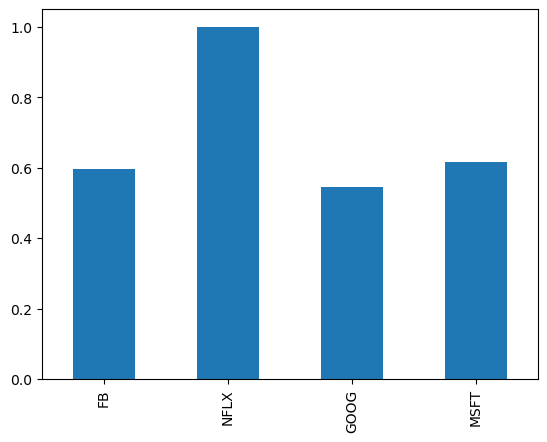

In [58]:
mult_df.corr()['NFLX'].plot(kind='bar')

<h2>Get the variance of a stock</h2>

In [61]:
print("Variance: ", mult_df['NFLX'].var())
# in an annualized form
days = len(mult_df.index)
print("Annualized Variance : ", mult_df['NFLX'].var() * days)

Variance:  0.0008542915350884244
Annualized Variance :  0.21613575837737137


<h2>Get Covariance of Stocks</h2>

In [62]:
mult_df.cov() * 253

,FB,NFLX,GOOG,MSFT
FB,0.215868,0.128576,0.145724,0.160259
NFLX,0.128576,0.216136,0.098242,0.127468
GOOG,0.145724,0.098242,0.149644,0.147653
MSFT,0.160259,0.127468,0.147653,0.197069


<h2>Calculating a Portfolio's Variance</h2>

When calculating the variance of a portfolio, one must establish its weight

$w_1,w_2$ = Stock Weights

$\sigma_1,\sigma_1$ = Stock standard deviations

Portfolio Variance = $(w_1\sigma_1 + w_2\sigma_2)^{2}$

since $(a+b)^{2} = a^{2} + 2ab+ b^{2}$

then the portfolio variance is $w_1^{2}\sigma_1^{2} + 2w_1\sigma_1w_2\sigma_2\rho_{1,2} + w_2^{2}\sigma_2^{2}$

In [64]:
port_list = ["FB","NEM"]
port_df = merge_df_by_column_name('daily_return','2020-1-1','2020-12-31',*port_list)

port_df

port_df.corr()

Working on :  FB
colname daily_return
Working on :  NEM
colname daily_return


,FB,NEM
FB,1.000000,0.186682
NEM,0.186682,1.000000


In [67]:
price_df = merge_df_by_column_name('Adj Close','2020-1-1','2020-12-31',*port_list)
price_df.head()

# weight = value of holding over value of all holdings
# one share of FB
fb_wt = 209.78 / 418.48
# 5 shares of WEM
new_wt = 208.70 / 418048

fb_wt = 0.5012
nem_wt = 0.4988
wts = np.array([fb_wt,nem_wt])
# transpose matrix
port_var = np.dot(wts.T, np.dot(port_df.cov() * 253, wts))
print("Portfolio Variance : ", port_var)
print("FB Variance : ", port_df['FB'].var()*253)
print("NEM Variance : ", port_df['NEM'].var()*253)

Working on :  FB
colname Adj Close
Working on :  NEM
colname Adj Close
Portfolio Variance :  0.12685748050948573
FB Variance :  0.21586759061066657
NEM Variance :  0.2117209133919327


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Zak\anaconda3\envs\financeEnv\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Zak\anaconda3\envs\financeEnv\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Zak\anaconda3\envs\financeEnv\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Zak\anaconda3\envs\financeEnv\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE